In [4]:
import os
import errno
import numpy as np 
import deepcell

In [5]:
# create folder for this set of experiments
experiment_folder = "20200227_IF_Training"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [6]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20200310_IF_Training_1"
test_size=0.1
seed=0
DATA_FILE = NPZ_DIR + npz_name + ".npz"
train_dict, test_dict = get_data(DATA_FILE, test_size=test_size, seed=seed)
X_train, y_train = train_dict['X'], train_dict['y']
X_test, y_test = test_dict['X'], test_dict['y']

X.shape: (624, 256, 256, 2)
y.shape: (624, 256, 256, 1)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]


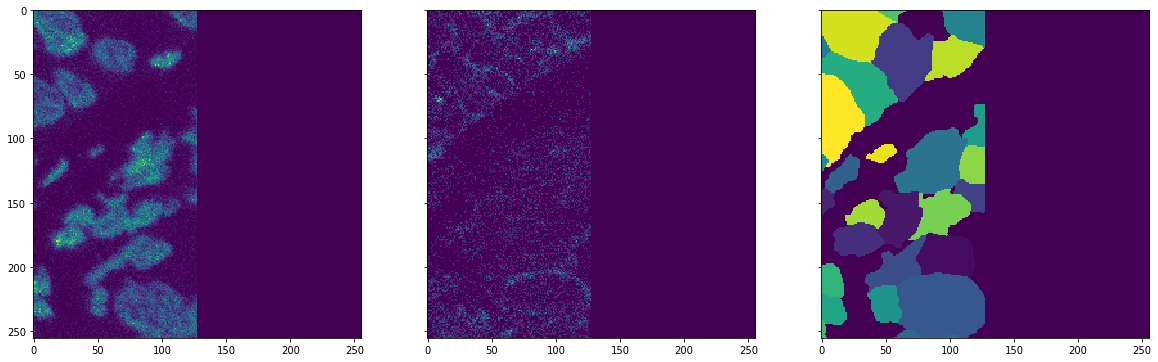

In [7]:
for i in range(y_train.shape[0]):
        y_train[i], _, _ = relabel_sequential(y_train[i])
        
for i in range(y_test.shape[0]):
        y_test[i], _, _ = relabel_sequential(y_test[i])
        
               
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 20), sharex=True, sharey=True)
axes[0].imshow(X_train[0,:,:,0])
axes[1].imshow(X_train[0,:,:,1])
axes[2].imshow(y_train[0,:,:,0])
print(np.unique(y_train[0]))

In [8]:
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[1:],
    norm_method='std',
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

W0311 17:46:58.906794 140363693664064 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


94773248/94765736 [==============================] - 2s 0us/step


In [9]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = npz_name + '_deep_watershed'

n_epoch = 20  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'std'  # data normalization

optimizer = Adam(lr=1e-5, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-5, decay=0.99)

batch_size = 1

min_objects = 3  # throw out images with fewer than this many objects
seed=0

In [10]:
from deepcell import image_generators
from deepcell.utils import train_utils


# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=['centroid', 'watershed-cont', 'fgbg', 'pixelwise'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 2}, 'pixelwise':{'dilation_radius': 1}, 
                      'centroid': {'erosion_width': 2}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    transforms=['centroid', 'watershed-cont', 'fgbg', 'pixelwise'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 2}, 'pixelwise':{'dilation_radius': 1},
                      'centroid': {'erosion_width': 2}},
    min_objects=min_objects,
    batch_size=batch_size)

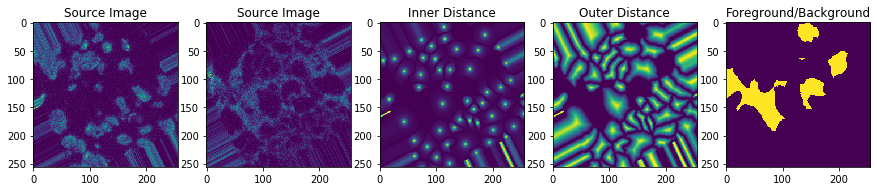

In [11]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]
#pixelwise = outputs[3]

fig, axes = plt.subplots(1, 5, figsize=(15, 15))

axes[0].imshow(img[:, :, 0])
axes[0].set_title('Source Image')

axes[1].imshow(img[:, :, 1])
axes[1].set_title('Source Image')

axes[2].imshow(inner_distance[0, ..., 0])
axes[2].set_title('Inner Distance')

axes[3].imshow(outer_distance[0, ..., 0])
axes[3].set_title('Outer Distance')

axes[4].imshow(fgbg[0, ..., 0])
axes[4].set_title('Foreground/Background')

plt.show()

In [12]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if 'semantic_' in layer.name:
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [13]:
model.compile(loss=loss, optimizer=optimizer)

In [14]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/20


W0311 17:52:07.147317 140363693664064 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


  1/624 [..............................] - ETA: 10:11:31 - loss: 0.5951 - semantic_0_loss: 0.5133 - semantic_1_loss: 0.0616 - semantic_2_loss: 0.0075 - semantic_3_loss: 0.0127

W0311 17:53:05.970389 140363693664064 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.574405). Check your callbacks.


  2/624 [..............................] - ETA: 5:08:25 - loss: 0.6367 - semantic_0_loss: 0.5286 - semantic_1_loss: 0.0881 - semantic_2_loss: 0.0075 - semantic_3_loss: 0.0126 

W0311 17:53:06.157624 140363693664064 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.301423). Check your callbacks.


623/624 [============================>.] - ETA: 0s - loss: 0.1788 - semantic_0_loss: 0.0738 - semantic_1_loss: 0.0904 - semantic_2_loss: 0.0051 - semantic_3_loss: 0.0096
Epoch 00001: val_loss improved from inf to 0.81878, saving model to /data/models/20200227_IF_Training/20200310_IF_Training_1_deep_watershed.h5
624/624 [==============================] - 244s 391ms/step - loss: 0.1787 - semantic_0_loss: 0.0737 - semantic_1_loss: 0.0903 - semantic_2_loss: 0.0051 - semantic_3_loss: 0.0096 - val_loss: 0.8188 - val_semantic_0_loss: 0.6914 - val_semantic_1_loss: 0.0986 - val_semantic_2_loss: 0.0102 - val_semantic_3_loss: 0.0186
Epoch 2/20
623/624 [============================>.] - ETA: 0s - loss: 0.0963 - semantic_0_loss: 0.0123 - semantic_1_loss: 0.0717 - semantic_2_loss: 0.0041 - semantic_3_loss: 0.0082
Epoch 00002: val_loss improved from 0.81878 to 0.11911, saving model to /data/models/20200227_IF_Training/20200310_IF_Training_1_deep_watershed.h5
624/624 [==============================] -

623/624 [============================>.] - ETA: 0s - loss: 0.0525 - semantic_0_loss: 0.0101 - semantic_1_loss: 0.0322 - semantic_2_loss: 0.0033 - semantic_3_loss: 0.0069
Epoch 00014: val_loss improved from 0.06379 to 0.06358, saving model to /data/models/20200227_IF_Training/20200310_IF_Training_1_deep_watershed.h5
624/624 [==============================] - 109s 175ms/step - loss: 0.0524 - semantic_0_loss: 0.0101 - semantic_1_loss: 0.0321 - semantic_2_loss: 0.0033 - semantic_3_loss: 0.0069 - val_loss: 0.0636 - val_semantic_0_loss: 0.0112 - val_semantic_1_loss: 0.0392 - val_semantic_2_loss: 0.0048 - val_semantic_3_loss: 0.0084
Epoch 15/20
623/624 [============================>.] - ETA: 0s - loss: 0.0514 - semantic_0_loss: 0.0099 - semantic_1_loss: 0.0314 - semantic_2_loss: 0.0033 - semantic_3_loss: 0.0069
Epoch 00015: val_loss improved from 0.06358 to 0.06271, saving model to /data/models/20200227_IF_Training/20200310_IF_Training_1_deep_watershed.h5
624/624 [============================

In [6]:
# load previous trained model
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[1:],
    norm_method='std',
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

model.load_weights(os.path.join(MODEL_DIR, npz_name + "_deep_watershed_pixel_transform_20_epoch.h5"))

W0308 00:39:39.278962 140164836943680 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


94773248/94765736 [==============================] - 3s 0us/step


In [15]:
from deepcell_toolbox.utils import tile_image

In [35]:
test_data, test_info = tile_image(cohort_xr.values, (256, 256), stride_ratio=0.5)

In [36]:
# make predictions on testing data
from timeit import default_timer

start = default_timer()
test_images = model.predict(test_data)
watershed_time = default_timer() - start

print('Watershed segmentation of shape', test_images[0].shape, 'in', watershed_time, 'seconds.')

Watershed segmentation of shape (121, 256, 256, 1) in 1.0783299630002148 seconds.


In [37]:
inner_distance, outer_distance, fgbg, pixelwise = test_images

In [19]:
def untile_image(tiles, tiles_info, dtype,
                 model_input_shape=(512, 512)):
    """Untile a set of tiled images back to the original model shape.
    Args:
        tiles (numpy.array): The tiled images image to untile.
        tiles_info (dict): Details of how the image was tiled (from tile_image).
        model_input_shape (tuple): The input size of the model.
    Returns:
        numpy.array: The untiled image.
    """
    _axis = 1
    image_shape = tiles_info['image_shape']
    batches = tiles_info['batches']
    x_starts = tiles_info['x_starts']
    x_ends = tiles_info['x_ends']
    y_starts = tiles_info['y_starts']
    y_ends = tiles_info['y_ends']
    stride_x = tiles_info['stride_x']
    stride_y = tiles_info['stride_y']

    tile_size_x = model_input_shape[0]
    tile_size_y = model_input_shape[1]

    image_shape = tuple(list(image_shape[0:3]) + [tiles.shape[-1]])
    image = np.zeros(image_shape, dtype=dtype)

    zipped = zip(tiles, batches, x_starts, x_ends, y_starts, y_ends)
    for tile, batch, x_start, x_end, y_start, y_end in zipped:
        tile_x_start = 0
        tile_x_end = tile_size_x
        tile_y_start = 0
        tile_y_end = tile_size_y

        if x_start != 0:
            x_start += (tile_size_x - stride_x) / 2
            tile_x_start += (tile_size_x - stride_x) / 2
        if x_end != image_shape[_axis]:
            x_end -= (tile_size_x - stride_x) / 2
            tile_x_end -= (tile_size_x - stride_x) / 2
        if y_start != 0:
            y_start += (tile_size_y - stride_y) / 2
            tile_y_start += (tile_size_y - stride_y) / 2
        if y_end != image_shape[_axis]:
            y_end -= (tile_size_y - stride_y) / 2
            tile_y_end -= (tile_size_y - stride_y) / 2

        x_start = np.int(x_start)
        x_end = np.int(x_end)
        y_start = np.int(y_start)
        y_end = np.int(y_end)

        tile_x_start = np.int(tile_x_start)
        tile_x_end = np.int(tile_x_end)
        tile_y_start = np.int(tile_y_start)
        tile_y_end = np.int(tile_y_end)

        image[batch, x_start:x_end, y_start:y_end, :] = \
            tile[tile_x_start:tile_x_end, tile_y_start:tile_y_end, :]

    return image

In [38]:
inner_distance_untile = untile_image(inner_distance, test_info, "float32", (256, 256))

In [39]:
outer_distance_untile = untile_image(outer_distance, test_info, "float32",(256, 256))

In [40]:
pixelwise_untile = untile_image(pixelwise, test_info, "float32", (256, 256))

In [41]:
combined = np.concatenate((pixelwise_untile[:, :, :, 1:2], inner_distance_untile, outer_distance_untile), axis=-1)
combined.shape

(1, 1500, 1500, 3)

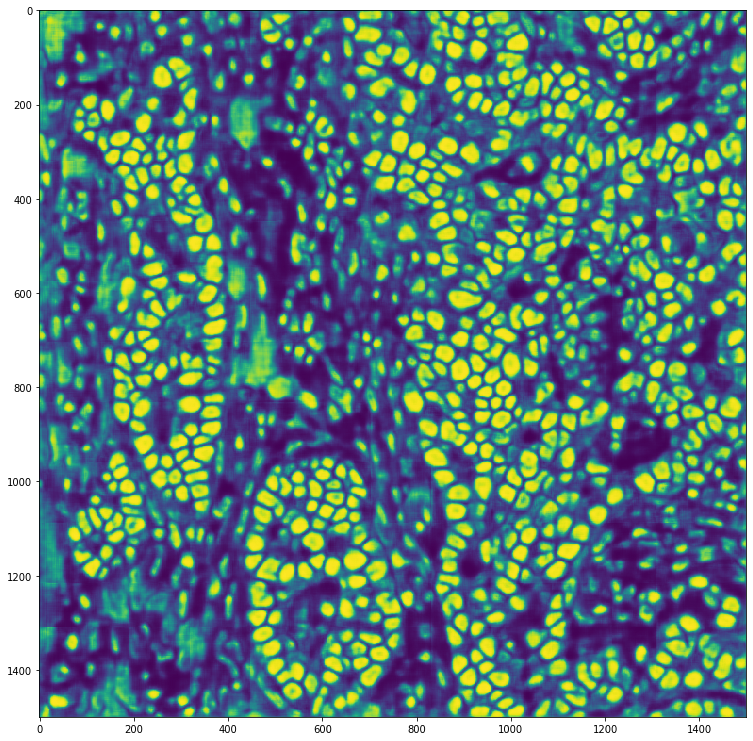

In [42]:
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(combined[0, :, :, 0])

In [22]:
model_output = xr.DataArray(combined,
                         coords=[cohort_xr.coords['points'], range(cohort_xr.shape[1]), 
                                 range(cohort_xr.shape[2]), 
                                 ['pixelwise_interior', 'watershed_inner', 'watershed_outer']],
                         dims=['points', 'rows', 'cols', 'models'])
model_output.to_netcdf(os.path.join(data_dir, "deep_watershed_v5_points_output.xr"), format="NETCDF4")

In [26]:
import scipy.ndimage as nd
def deep_watershed(outputs,
                   min_distance=10,
                   detection_threshold=0.1,
                   distance_threshold=0.01,
                   exclude_border=False,
                   small_objects_threshold=0):
    """Postprocessing function for deep watershed models. Thresholds the inner
    distance prediction to find cell centroids, which are used to seed a marker
    based watershed of the outer distance prediction.
    Args:
        outputs (list): DeepWatershed model output. A list of
            [inner_distance, outer_distance, fgbg].
            - inner_distance: Prediction for the inner distance transform.
            - outer_distance: Prediction for the outer distance transform.
            - fgbg: Prediction for the foregound/background transform.
        min_distance (int): Minimum allowable distance between two cells.
        detection_threshold (float): Threshold for the inner distance.
        distance_threshold (float): Threshold for the outer distance.
        exclude_border (bool): Whether to include centroid detections
            at the border.
        small_objects_threshold (int): Removes objects smaller than this size.
    Returns:
        numpy.array: Uniquely labeled mask.
    """
    inner_distance_batch = outputs[0][:, ..., 0]
    print("using pixelwise background for watershed")
    outer_distance_batch = outputs[3][:, ..., 1]
    outer_distance_batch = nd.gaussian_filter(outer_distance_batch, 3)
    fgbg_batch = outputs[2]

    label_images = []
    for batch in range(inner_distance_batch.shape[0]):
        inner_distance = inner_distance_batch[batch]
        outer_distance = outer_distance_batch[batch]

        coords = peak_local_max(inner_distance,
                                min_distance=min_distance,
                                threshold_abs=detection_threshold,
                                exclude_border=exclude_border)

        markers = np.zeros(inner_distance.shape)
        markers[coords[:, 0], coords[:, 1]] = 1
        markers = label(markers)
        label_image = watershed(-outer_distance,
                                markers,
                                mask=outer_distance > distance_threshold)
        label_image = erode_edges(label_image, 1)

        # Remove small objects
        #label_image = remove_small_objects(label_image, min_size=small_objects_threshold)

        # Relabel the label image
        label_image, _, _ = relabel_sequential(label_image)

        label_images.append(label_image)

    label_images = np.stack(label_images, axis=0)

    return label_images

0
using pixelwise background for watershed


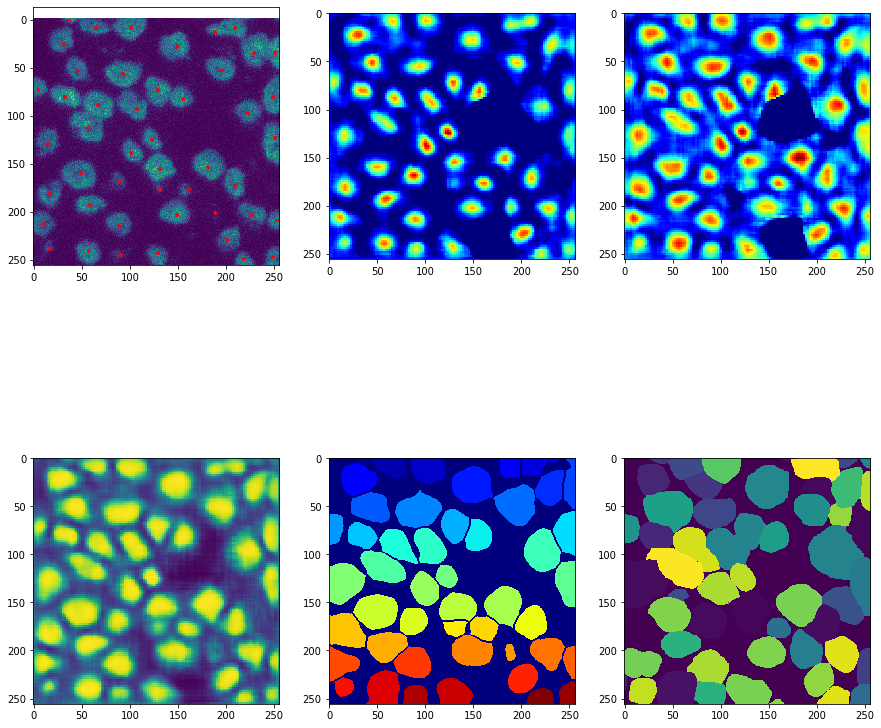

In [33]:
import time

from matplotlib import pyplot as plt
import numpy as np

#from deepcell_toolbox.deep_watershed import deep_watershed

from skimage.exposure import equalize_adapthist
from skimage.measure import label
from skimage.morphology import watershed
from deepcell.utils.transform_utils import erode_edges

from scipy import ndimage
from skimage.feature import peak_local_max

index = np.random.choice(X_test.shape[0])
print(index)

fig, axes = plt.subplots(2, 3, figsize=(15, 15))

inner_distance, outer_distance, fgbg, pixelwise = test_images
#index = 0

masks = deep_watershed(
    test_images,
    min_distance=10,
    detection_threshold=0.1,
    distance_threshold=0.35,
    exclude_border=False,
    small_objects_threshold=0)

# calculated in the postprocessing above, but useful for visualizing
coords = peak_local_max(
    inner_distance[index],
    min_distance=10,
    threshold_abs=0.1,
    exclude_border=False)

# raw image with centroid
axes[0,0].imshow(X_test[index, ..., 0])
axes[0,0].scatter(coords[..., 1], coords[..., 0],
                color='r', marker='.', s=10)

axes[0,1].imshow(inner_distance[index, ..., 0], cmap='jet')
axes[0,2].imshow(outer_distance[index, ..., 0], cmap='jet')
axes[1, 0].imshow(pixelwise[index, ..., 1])
axes[1, 1].imshow(masks[index, ...], cmap='jet')
axes[1, 2].imshow(y_test[index, :, :, 0])

plt.show()

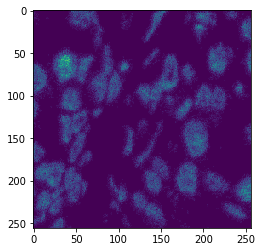

In [46]:
plt.imshow(X_test2[6, :, :, 0])

In [39]:
X_test2= np.zeros((16, 256, 256, 2))
counter = 0
for row in range(4):
    for col in range(4):
        X_test2[counter, :, :, :] = X_test[0, row * 256 : (row + 1) * 256, col * 256 : (col + 1) * 256, :]
        counter += 1
        

In [53]:
y_test2= np.zeros((16, 256, 256, 1))
counter = 0
for row in range(4):
    for col in range(4):
        y_test2[counter, :, :, :] = y_test[0, row * 256 : (row + 1) * 256, col * 256 : (col + 1) * 256, :]
        counter += 1
        

In [54]:
from deepcell.metrics import Metrics
from skimage.morphology import watershed, remove_small_objects
from skimage.segmentation import clear_border
from skimage.feature import peak_local_max

outputs = model.predict(X_test2)

y_pred = []

for i in range(outputs[0].shape[0]):

    mask = deep_watershed(
        [t[[i]] for t in outputs],
        min_distance=10,
        detection_threshold=0.1,
        distance_threshold=0.01,
        exclude_border=False,
        small_objects_threshold=0)

    y_pred.append(mask[0])

y_pred = np.stack(y_pred, axis=0)
y_pred = np.expand_dims(y_pred, axis=-1)
y_true = y_test2.copy()

print('DeepWatershed - Remove no pixels')
m = Metrics('DeepWatershed - Remove no pixels', seg=False)
m.calc_object_stats(y_true, y_pred)
print('\n')


for i in range(y_pred.shape[0]):
    y_pred[i] = remove_small_objects(y_pred[i].astype(int), min_size=100)
    y_true[i] = remove_small_objects(y_true[i].astype(int), min_size=100)


print('DeepWatershed - Remove objects < 100 pixels')
m = Metrics('DeepWatershed - Remove 100 pixels', seg=False)
m.calc_object_stats(y_true, y_pred)
print('\n')

using regular background for watershed
using regular background for watershed
using regular background for watershed
using regular background for watershed
using regular background for watershed
using regular background for watershed
using regular background for watershed
using regular background for watershed
using regular background for watershed
using regular background for watershed
using regular background for watershed
using regular background for watershed
using regular background for watershed
using regular background for watershed
using regular background for watershed
using regular background for watershed
DeepWatershed - Remove no pixels

____________Object-based statistics____________

Number of true cells:		 656
Number of predicted cells:	 552

Correct detections:  306	Recall: 46.64634146341463605267563252709805965423583984375%
Incorrect detections: 246	Precision: 55.43478260869564877566517679952085018157958984375%

Gained detections: 175	Perc Error: 36.6876310272536656498